## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [31]:
import string
import os
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [32]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
print(text)
assert len(text) == 2616

['  From fairest creatures we desire increase,\n', "  That thereby beauty's rose might never die,\n", '  But as the riper should by time decease,\n', '  His tender heir might bear his memory:\n', '  But thou, contracted to thine own bright eyes,\n', "  Feed'st thy light's flame with self-substantial fuel,\n", '  Making a famine where abundance lies,\n', '  Thy self thy foe, to thy sweet self too cruel:\n', "  Thou that art now the world's fresh ornament,\n", '  And only herald to the gaudy spring,\n', '  Within thine own bud buriest thy content,\n', "  And tender churl mak'st waste in niggarding:\n", '    Pity the world, or else this glutton be,\n', "    To eat the world's due, by the grave and thee.\n", '\n', '  II\n', '\n', '  When forty winters shall besiege thy brow,\n', "  And dig deep trenches in thy beauty's field,\n", "  Thy youth's proud livery so gazed on now,\n", "  Will be a tatter'd weed of small worth held:\n", '  Then being asked, where all thy beauty lies,\n', '  Where 

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [33]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = [x.lower() for x in text]
text = ''.join(text)
text = text[:3000]

# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
# assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2023-12-20 12:09:13--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2023-12-20 12:09:13 (7.94 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [34]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = [x.lower() for x in text]
text = ''.join(text)




Put all the characters, that you've seen in the text, into variable `tokens`.

In [35]:
tokens = sorted(set(text))
print(tokens)

['\n', ' ', '!', "'", ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [36]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {idx: token for idx, token in enumerate(tokens)}


In [37]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [38]:
data = torch.zeros( (len(text),1), dtype=torch.int64, device=device)
for i,ch in enumerate(text):
  data[i] = token_to_idx[ch]


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [39]:
# Your code here
# Модель для LSTM
class lstmnet(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, num_layers):
    super().__init__()

    # embedding
    self.embedding = nn.Embedding(input_size,input_size)

    # LSTM
    self.lstm = nn.LSTM(input_size,hidden_size,num_layers)

    # linear (output)
    self.out = nn.Linear(hidden_size,output_size)


  def forward(self,x,h):

    # embedding
    embedding = self.embedding(x)

    # пропускаем через RNN layer
    y,h = self.lstm(embedding,h)

    # output (linear) layer
    y = self.out(y)

    return y,(h[0].detach(),h[1].detach()) # оставлем только числа для h

In [40]:
# meta-parameters (Мета праметры)
hidden_size = 512   # размер hidden state
seqlength   = 80    # длина последовательности
num_layers  = 3     # количество скрытых слоев
epochs      = 10    # количество тренировочных эпох

In [41]:
# Создаем модель
lstm = lstmnet(len(tokens),len(tokens), hidden_size, num_layers).to(device)

# Функция потерь и оптимайзер
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=.001)

In [42]:
losses = np.zeros(epochs)


# Цикл по эпохам
for epochi in range(epochs):

  # для этой эпохи инициализируем loss и hidden state
  txtloss = 0
  hidden_state = None

  # цикл по всему тексту (по токенам)
  for txtloc in range(0,len(text)-seqlength):

    # get input and target (shifted version of input)
    x = data[txtloc   : txtloc+seqlength  ]
    y = data[txtloc+1 : txtloc+seqlength+1]

    # forward pass
    output, hidden_state = lstm(x,None)

    # compute loss
    loss = lossfun(torch.squeeze(output), torch.squeeze(y))
    txtloss += loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # average losses for this epoch (run through the entire text)
  losses[epochi] = txtloss/txtloc


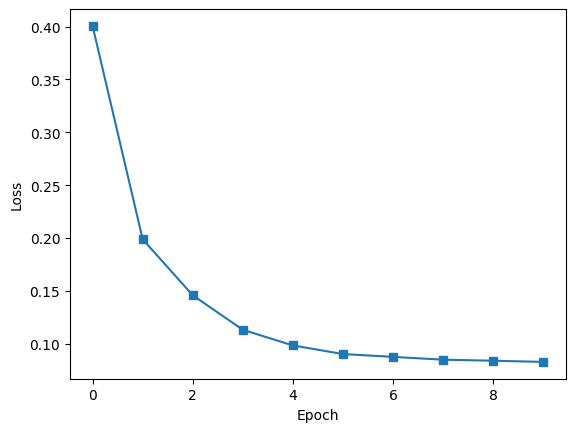

In [43]:
# check out the losses
plt.plot(losses,'s-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [44]:
# reconstructing a character sequence from number sequence
t = ''
for l in x:
  t += idx_to_token[l.item()]

t

"ty o'er-snowed and bareness every where:\n  then were not summer's distillation l"

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [46]:
# GENERATION LSTM

# how many characters to generate?
text_gen_length = 200

# random character from data to begin
x = torch.tensor(token_to_idx['x']).view(1,1).to(device)
text_gen = idx_to_token[x.item()]

# initialize the hidden state
hidden_state = None


# generate the text!
for i in range(text_gen_length):

  # push a letter though the LSTM
  output, hidden_state = lstm(x,hidden_state)

  # get the maximum output and replace input data
  index = torch.argmax(output).item()
  x[0][0] = index

  # append that output to the text
  text_gen += idx_to_token[index]


## what's it say?!?!?!
text_gen

#ТЕКСТ ГЕНЕРАЦИИ НИЖЕ:

"xcel;\n  for never-resting time leads summer's distillation leaves quite gone,\n  beauty o'er-snowed and bareness every where:\n  then were not summer's distillation leaves quite gone,\n  beauty o'er-snowe"